# Inception V1


In [116]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [117]:
class EMNISTDataset(Dataset):
    def __init__(self, df, transform=None):
        self.labels = df.iloc[:, 0].values - 1   # letters are 1–26 → convert to 0–25
        self.images = df.iloc[:, 1:].values.astype(np.uint8)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx].reshape(28, 28)   # grayscale
        img = np.stack([img, img, img], axis=2)  # 3 channels

        img = Image.fromarray(img)

        if self.transform:
            img = self.transform(img)

        label = torch.tensor(self.labels[idx]).long()
        return img, label


In [118]:
train_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

test_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])


In [119]:
full_ds = EMNISTDataset(train_data, transform=train_tf)

n_total = len(full_ds)
n_train = int(0.8 * n_total)
n_val   = int(0.1 * n_total)
n_test  = n_total - n_train - n_val

train_ds, val_ds, test_ds = random_split(
    full_ds, [n_train, n_val, n_test],
    generator=torch.Generator().manual_seed(123)
)

val_ds.dataset.transform = test_tf
test_ds.dataset.transform = test_tf

print("Train:", len(train_ds), "Val:", len(val_ds), "Test:", len(test_ds))


Train: 71040 Val: 8880 Test: 8880


In [120]:
batch_size = 64

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)


In [121]:
model = models.googlenet(
    weights=models.GoogLeNet_Weights.IMAGENET1K_V1,
    aux_logits=True
)

num_classes = 26

# main classifier
model.fc = nn.Linear(model.fc.in_features, num_classes)

# auxiliary classifiers
model.aux1.fc2 = nn.Linear(model.aux1.fc2.in_features, num_classes)
model.aux2.fc2 = nn.Linear(model.aux2.fc2.in_features, num_classes)

model = model.to(device)


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 183MB/s] 
/usr/local/lib/python3.11/dist-packages/torchvision/models/googlenet.py:341: UserWarning: auxiliary heads in the pretrained googlenet model are NOT pretrained, so make sure to train them
  warnings.warn(


In [122]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3)

best_acc = 0
best_model_path = "googlenet_emnist_best.pth"
epochs = 10


In [123]:
for epoch in range(epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs, aux1, aux2 = model(imgs)

        loss = (
            criterion(outputs, labels) +
            0.3 * criterion(aux1, labels) +
            0.3 * criterion(aux2, labels)
        )

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total

    # validation
    model.eval()
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            out = model(imgs)
            preds = out.argmax(dim=1)

            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    scheduler.step(1 - val_acc)

    print(f"Epoch {epoch+1}: Train Acc={train_acc:.3f}, Val Acc={val_acc:.3f}")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print("Saved best model!")


Epoch 1: Train Acc=0.899, Val Acc=0.949
Saved best model!
Epoch 2: Train Acc=0.950, Val Acc=0.952
Saved best model!
Epoch 3: Train Acc=0.956, Val Acc=0.956
Saved best model!
Epoch 4: Train Acc=0.962, Val Acc=0.955
Epoch 5: Train Acc=0.966, Val Acc=0.953
Epoch 6: Train Acc=0.969, Val Acc=0.957
Saved best model!
Epoch 7: Train Acc=0.971, Val Acc=0.952
Epoch 8: Train Acc=0.973, Val Acc=0.956
Epoch 9: Train Acc=0.976, Val Acc=0.956
Epoch 10: Train Acc=0.977, Val Acc=0.947


In [124]:
model.load_state_dict(torch.load(best_model_path))
model.eval()

test_correct = 0
test_total = 0

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        out = model(imgs)
        preds = out.argmax(dim=1)

        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)

print("Test Accuracy:", test_correct / test_total)


Test Accuracy: 0.9518018018018019


In [126]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from sklearn.metrics import confusion_matrix
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize

model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model(imgs)

        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)


In [127]:
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels, all_preds, average="macro"
)

print("Accuracy:", accuracy)
print("Precision (macro):", precision)
print("Recall (macro):", recall)
print("F1-score (macro):", f1)


Accuracy: 0.9518018018018019
Precision (macro): 0.953319812674465
Recall (macro): 0.9525187168171367
F1-score (macro): 0.9523684811083434


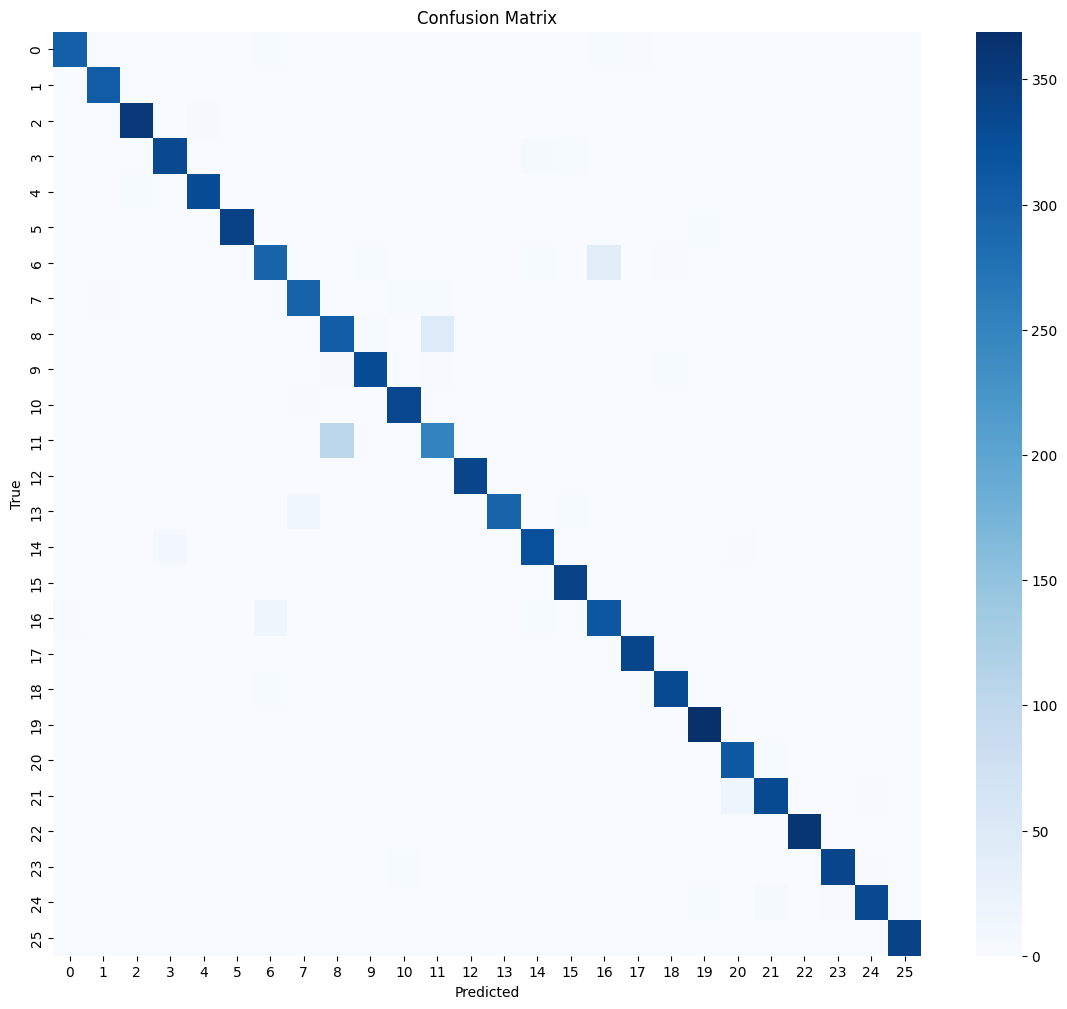

In [128]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


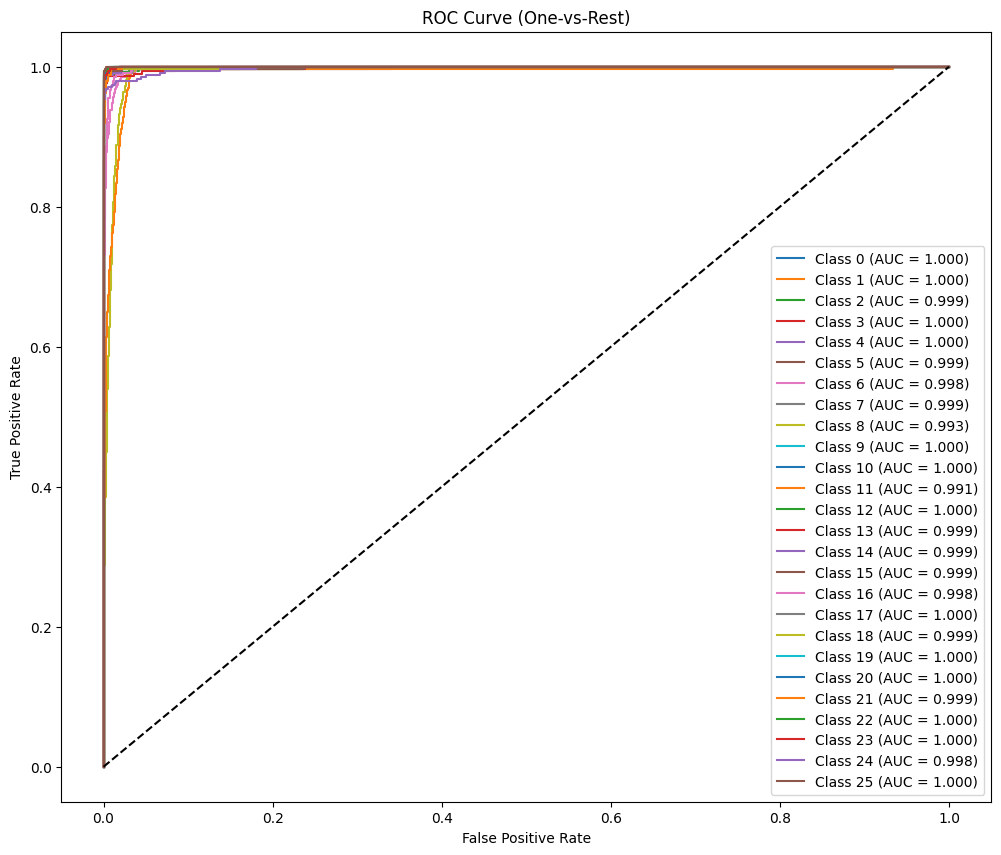

In [129]:
from sklearn.metrics import roc_curve, auc

num_classes = all_probs.shape[1]

# تحويل labels إلى multi-label format
labels_bin = label_binarize(all_labels, classes=list(range(num_classes)))

plt.figure(figsize=(12, 10))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(labels_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], "k--")  # خط random baseline
plt.title("ROC Curve (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


In [ ]:
# Save Inception (GoogLeNet) best model weights to project saved_models
import os
import torch

save_dir = '../saved_models/inception'
os.makedirs(save_dir, exist_ok=True)

# Assumes `model` currently holds best weights (loaded after training)
final_path = os.path.join(save_dir, 'final_emnist_inceptionv1.pth')
torch.save(model.state_dict(), final_path)
print(f"✅ InceptionV1 weights saved to: {final_path}")